In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx # to draw dags

 Linear Regressions

Today's tutorial will build upon our simulated frogs scenario and introduce some basic causal models and linear regressions.

## **Bayesian Workflow**

1.  Define what we are estimating ***(Causal Structure)***

2.  Build generative model to simulate data

    a.  Standardize data

3.  Build statistical model

    a.  Prior Predictive Simulation

4.  Validate statistical model with simulated data

    a.  Posterior Predictive Simulatio

### Define what we are estimating ***(Causal Structure)***

Last week, we went to a pond 30 times and recorded the presence/absence of frogs. This time, let's imagine when we go to the pond and see frogs, we capture them, record their length, weight and sex then toss them back in.

While recording this data we notice that smaller frogs tend to weigh less than larger frogs, and we want to describe this relationship between weight and length.

**Q. How does length influence weight?**

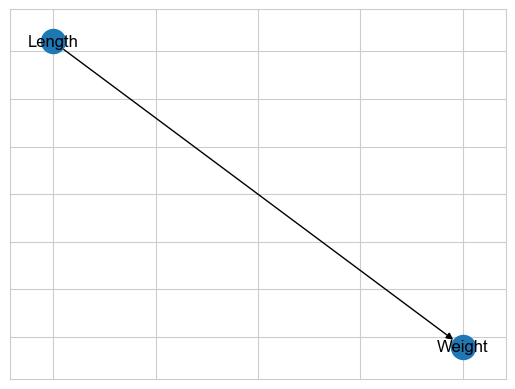

In [15]:
# causal model of our question
graph = nx.DiGraph()
graph.add_edges_from(
    [("Length", "Weight" )]
)
nx.draw_networkx(graph, arrows=True, pos=nx.spring_layout(graph))

It is important that we state our causal assumptions. Why is there an arrow going between Length and Weight? Here it is quite simple, as a frog gets longer it is reasonable to assume it also gets heavier.

What we are also implying in this causal model that:

**Weight is a function of Length**.

$$
Weight_i = \beta Length_i 
$$

But we know that weight is not just a function of Length, there are other factors that are unobserved that can influence weight

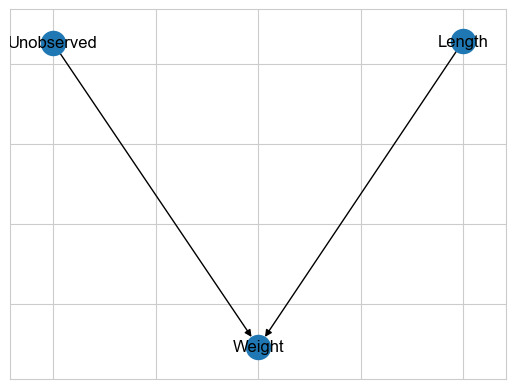

In [16]:
# causal model of our question
graph = nx.DiGraph()
graph.add_edges_from(
    [("Length", "Weight" ), ("Unobserved", "Weight")]
)
nx.draw_networkx(graph, arrows=True, pos=nx.spring_layout(graph))

This changes our generative model to:

$$
\large{
Weight_i = \beta_L Length_i + Unobserved
}
$$
  

### Define generative model and simulate data


Text(0, 0.5, 'Frog Weight (g)')

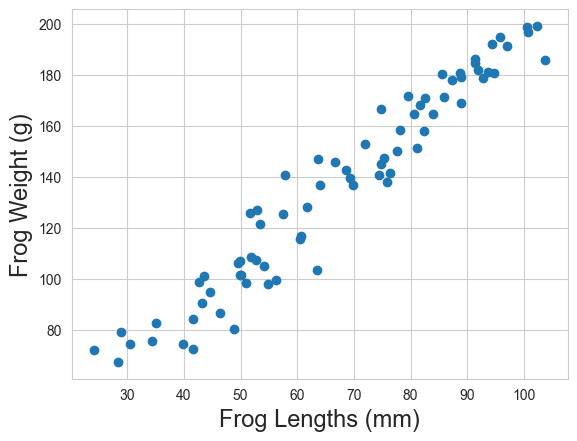

In [35]:
# using our generative model above we can simulate our data set

# number of frogs
n_frogs = 75

# function to generate weights base on given lengths
def simulate_weight(lengths, sd, b):
    """
    :param lengths: an array of lengths
    :param sd:  standard deviation of unobsrevd noise
    :param b:  the strength and direction of the relationship we want to generate 1 = strong postitve, -1 strong negative
    :return: 
    """
    unobserved = sp.stats.norm(0, sd).rvs(len(lengths))
    weights = b*lengths + unobserved
    return weights

# generate our frogs
lengths = sp.stats.uniform(65, 145).rvs(n_frogs) # give me 75 frog lengths between 65 and 145 mm 
weights = simulate_weight(lengths, sd=5, b=0.5)

# plot our data
plt.scatter(weights, lengths)
plt.xlabel('Frog Lengths (mm)', fontsize=17)
plt.ylabel('Frog Weight (g)', fontsize=17)

#### Standardize data

Text(0, 0.5, 'Frog Weight (g)')

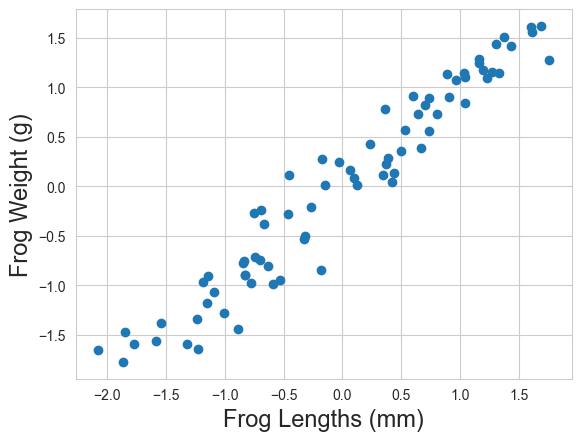

In [36]:
lengths_std = sp.stats.zscore(lengths)
weights_std = sp.stats.zscore(weights)

# plot our standardized data
plt.scatter(weights_std, lengths_std)
plt.xlabel('Frog Lengths (mm)', fontsize=17)
plt.ylabel('Frog Weight (g)', fontsize=17)

### Build our statistical model

$$
\large{
\begin{align*}
Weight_i \sim Normal(mu_i, sigma)\\
mu_i = alpha + \beta Length_i\\
alpha \sim Normal(0,1)\\
\beta \sim Normal(0,1)\\
sigma \sim Exp(1)
\end{align*}}
$$


#### Prior predictive simulation

Text(0, 0.5, 'Frog Weight (g)')

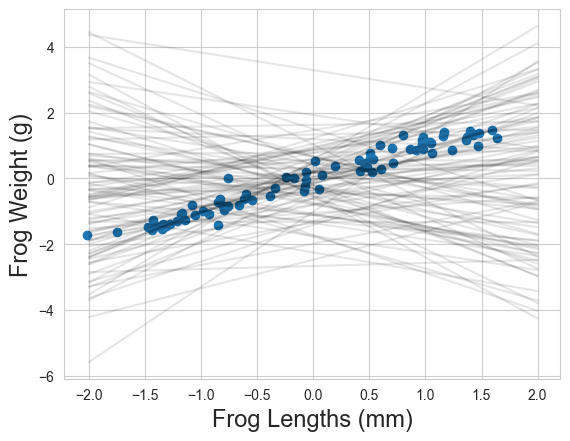

In [25]:
# simulate from our priors
# number of samples
n_samps = 100
# alpha (intercept) prior
alpha_prior = sp.stats.norm(0,1).rvs(n_samps)
# beta (slope/effect_size) prior
beta_prior = sp.stats.norm(0,1).rvs(n_samps)

# Plot resulting lines given sample values for alpha_prior and beta_prior, using a list comprehension
# range to plot over
length_seq = np.linspace(-2, 2, n_samps)
plt.scatter(weights_std, lengths_std)
[plt.plot(length_seq, a_prior+b_prior*length_seq, c='black', alpha=0.1) for a_prior,b_prior in zip(alpha_prior,beta_prior)];
plt.xlabel('Frog Lengths (mm)', fontsize=17)
plt.ylabel('Frog Weight (g)', fontsize=17)

These priors are incredible uninformative, they predict both strongly positive and negative relationships. We can do better than this, priors should express scientific knowledge, but do so with some flexibility.

We know that generally weight increases with length, we can force this relationship to be positive by sampling from a log normal distribution

Text(0, 0.5, 'Frog Weight (g)')

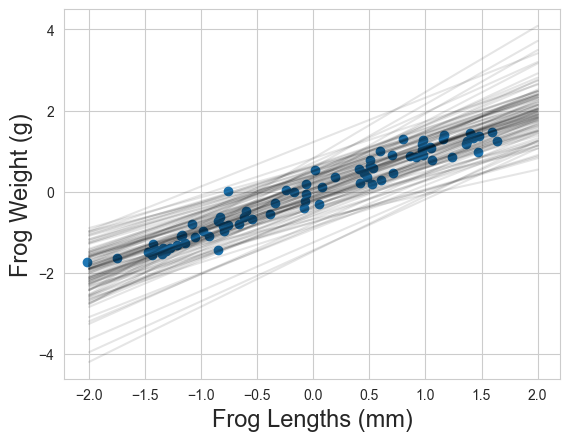

In [30]:
# simulate from our priors
# number of samples
n_samps = 100
# alpha (intercept) prior
alpha_prior = sp.stats.norm(0,0.5).rvs(n_samps)
# beta (slope/effect_size) prior
beta_prior = sp.stats.lognorm(loc=0,s=0.2).rvs(size=n_samps)

# Plot resulting lines given sample values for alpha_prior and beta_prior, using a list comprehension
# range to plot over
length_seq = np.linspace(-2, 2, n_samps)
plt.scatter(weights_std, lengths_std)
[plt.plot(length_seq, a_prior+b_prior*length_seq, c='black', alpha=0.1) for a_prior,b_prior in zip(alpha_prior,beta_prior)];
plt.xlabel('Frog Lengths (mm)', fontsize=17)
plt.ylabel('Frog Weight (g)', fontsize=17)

Run statistical model

In [130]:
with pm.Model() as length_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5)
    betaL = pm.LogNormal("betaL", 0, 0.2)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + betaL*lengths_std)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    length_idata = pm.sample()

az.summary(length_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betaL, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.029,-0.050,0.055,0.000,0.0,6206.0,3168.0,1.0
betaL,0.969,0.029,0.914,1.023,0.000,0.0,5790.0,3054.0,1.0
mu[0],-0.231,0.030,-0.288,-0.179,0.000,0.0,6237.0,3142.0,1.0
mu[1],-1.337,0.050,-1.426,-1.239,0.001,0.0,6050.0,3449.0,1.0
mu[2],1.106,0.043,1.025,1.186,0.001,0.0,5801.0,3132.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[71],-0.269,0.030,-0.328,-0.218,0.000,0.0,6248.0,3165.0,1.0
mu[72],-0.735,0.036,-0.806,-0.670,0.000,0.0,6175.0,3084.0,1.0
mu[73],1.039,0.041,0.961,1.117,0.001,0.0,5816.0,3082.0,1.0
mu[74],-1.244,0.047,-1.336,-1.157,0.001,0.0,6068.0,3488.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

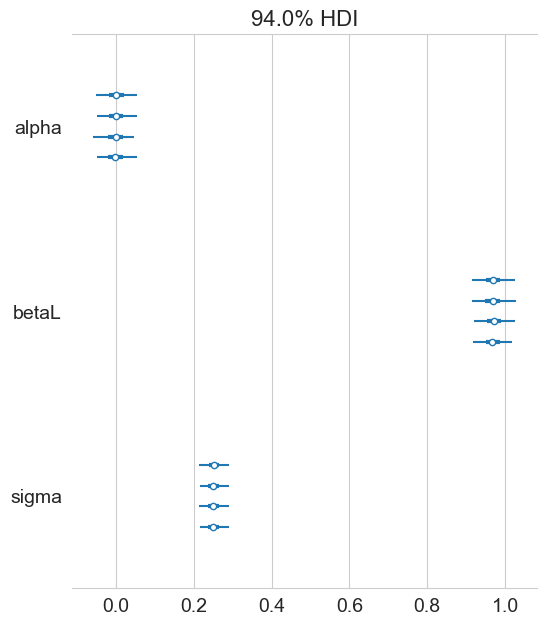

In [142]:
az.plot_forest(length_idata, filter_vars='regex', var_names=['alpha', 'beta', 'sigma'])

### Posterior Predictive plot

Here we check the predictions that are implied by our model against our data. 
We do this to see if the model correctly approximated the posterior distribution and to gain insights into how the model fails. Most often a model makes good predictions in some observations but not others. 
We can then go and inspect those individual observations to get an idea of how to improve our model.

In [131]:
# get estimates of mu for each individual frog and put them in a dataframe
mu = length_idata['posterior']['mu'].values[0,]
# calculate mean of each individual frog
mu_mean = np.median(mu, axis=0)

In [132]:
# uncertainity intervals
y_l95 = np.percentile(mu,2.5,axis=0)
y_u95 = np.percentile(mu,97.5,axis=0)

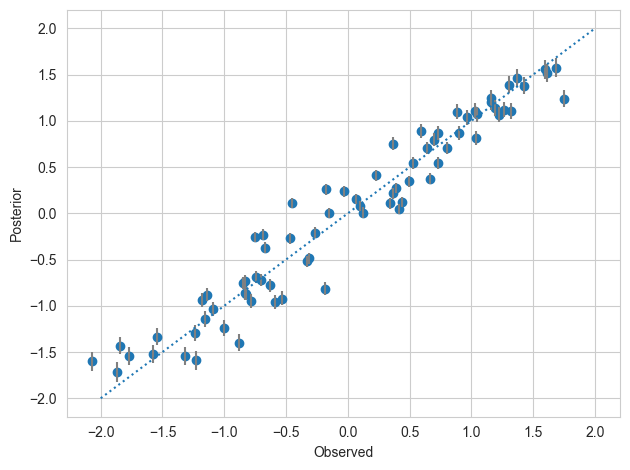

In [133]:
# Plot expected vs observed
plt.vlines(weights_std, y_l95, y_u95, colors='grey')
plt.scatter(weights_std, mu_mean)
plt.plot((-2, 2), (-2, 2), linestyle=":")
plt.xlabel('Observed')
plt.ylabel('Posterior')
plt.tight_layout()


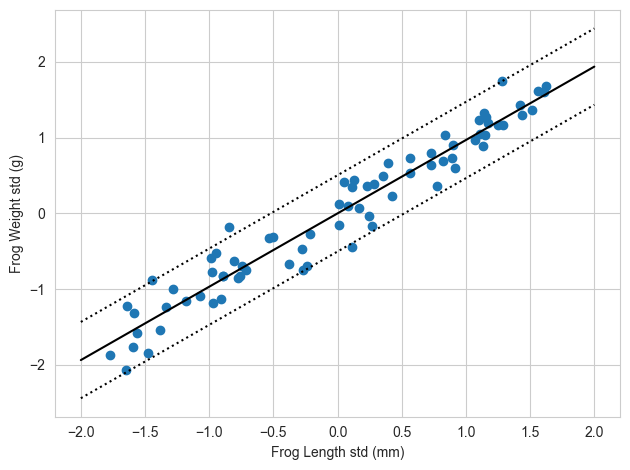

In [135]:
# estimate regression line from posterior
y = length_idata['posterior']['alpha'].mean().values + length_idata['posterior']['betaL'].mean().values*length_seq
# calculate uncertainty intervals
y_uu = y+length_idata['posterior']['sigma'].mean().values*2
y_ul = y-length_idata['posterior']['sigma'].mean().values*2
# plot out original data
plt.scatter(lengths_std, weights_std)
# plot posterior regression line
plt.plot(length_seq, y,c='black')
# plot uncertainty intervals
plt.plot(length_seq, y_uu, ":", c='black')
plt.plot(length_seq, y_ul, ":", c='black')
plt.xlabel('Frog Length std (mm)')
plt.ylabel('Frog Weight std (g)')
plt.tight_layout()

## Multiple Linear Regression: Adding another covariate and spurious correlations

Let us add another covariate into our casual model. We are going to make this pretty far fetched to emphasize the points made in lecture of spurious correlation. Let's add colour into the mix!

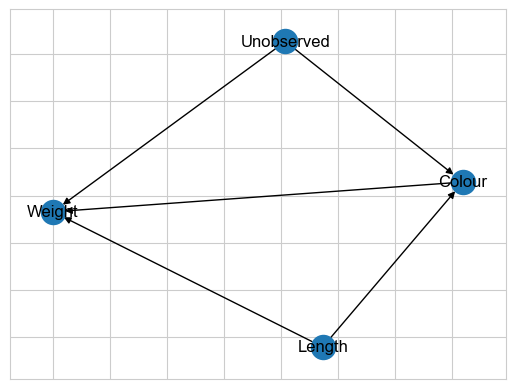

In [106]:
# causal model of our question
graph = nx.DiGraph()
graph.add_edges_from(
    [("Length", "Weight" ), ("Unobserved", "Weight"), ("Unobserved", "Colour"), ("Length", "Colour"), ("Colour", "Weight")]
)
nx.draw_networkx(graph, arrows=True, pos=nx.spring_layout(graph))

My causal assumptions stated in this model are

Length -\> Weight: As a frog gets longer it gets heavier.

Length -\> Colour: As a frog gets longer its colour changes.

Colour -\> Weight: As a frog changes colour it also causes changes to weight ???

The functional implications of this casual model are:

$$
\large{
\begin{align*}
& Weight_i = \beta_L Length_i + \beta_C Colour_i + unobserved \\
& Colour_i = \beta_L Colour_i + unobserved \\
\end{align*}}
$$

Text(0, 0.5, 'Frog Colours')

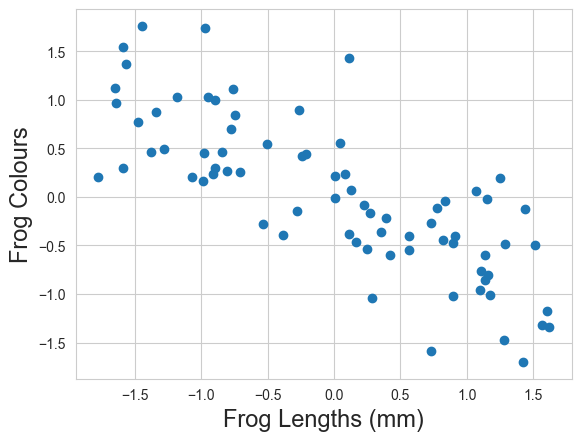

In [172]:
# function to generate colours based on given lengths
def simulate_colours(lengths, sd, b):
    """
    :param lengths: an array of lengths
    :param sd:  standard deviation of unobsrevd noise
    :param b:  the strength and direction of the relationship we want to generate 1 = strong postitve, -1 strong negative
    :return: 
    """
    unobserved = sp.stats.norm(0, sd).rvs(len(lengths))
    colours = b*lengths + unobserved
    return colours

# generate our frog
colours = simulate_colours(lengths_std, sd=0.5, b=-0.6)

# plot our data
plt.scatter(lengths_std, colours)
plt.xlabel('Frog Lengths (mm)', fontsize=17)
plt.ylabel('Frog Colours', fontsize=17)

Text(0.5, 0, 'Frog Colours')

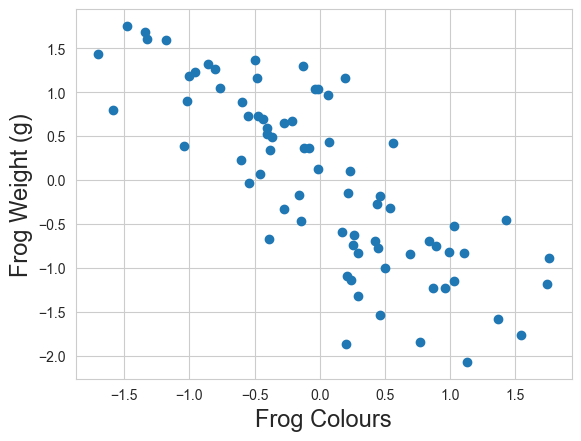

In [173]:
# here is the kicker, the relationship between weight and colour - even though we have never simulated any data between the two
plt.scatter(colours, weights_std)
plt.ylabel('Frog Weight (g)', fontsize=17)
plt.xlabel('Frog Colours', fontsize=17)

In [177]:
# colour and weight linear regression
with pm.Model() as colour_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5)
    betaC = pm.Normal("betaC", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + betaC*colours)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    colour_idata = pm.sample()

az.summary(colour_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betaC, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.021,0.071,-0.112,0.151,0.001,0.001,5282.0,3387.0,1.0
betaC,-1.004,0.090,-1.165,-0.829,0.001,0.001,5542.0,2965.0,1.0
mu[0],-0.405,0.079,-0.565,-0.267,0.001,0.001,5669.0,3264.0,1.0
mu[1],-0.440,0.080,-0.599,-0.294,0.001,0.001,5717.0,3049.0,1.0
mu[2],0.880,0.108,0.674,1.084,0.001,0.001,5495.0,3246.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[71],0.163,0.073,0.032,0.304,0.001,0.001,5275.0,3322.0,1.0
mu[72],-1.093,0.119,-1.308,-0.858,0.002,0.001,6092.0,3234.0,1.0
mu[73],-0.044,0.071,-0.173,0.090,0.001,0.001,5289.0,3375.0,1.0
mu[74],-0.478,0.082,-0.638,-0.327,0.001,0.001,5762.0,3103.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

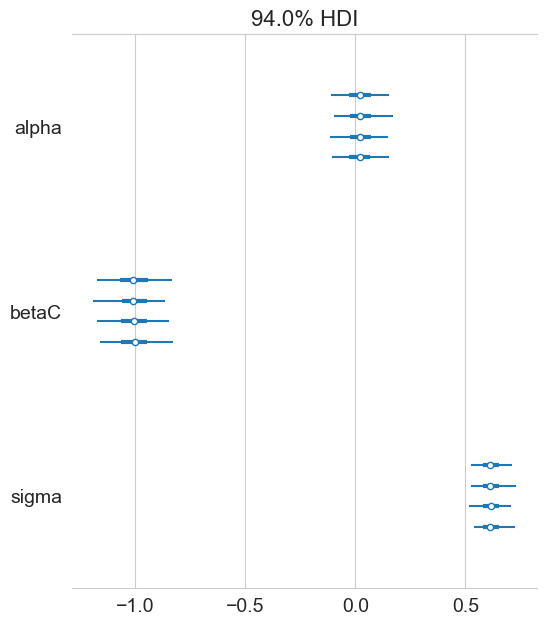

In [178]:
az.plot_forest(colour_idata, filter_vars='regex', var_names=['alpha', 'beta', 'sigma'])

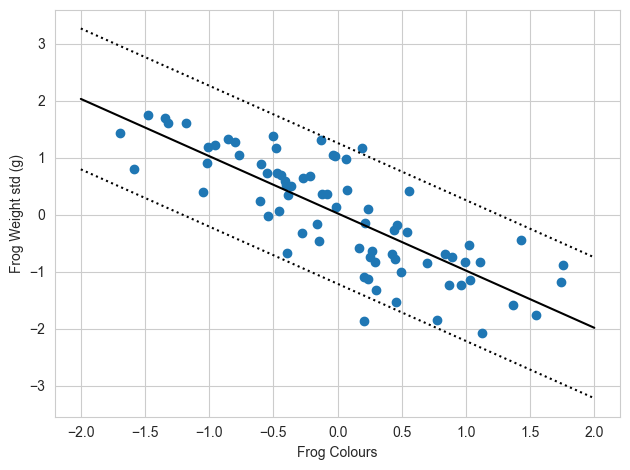

In [179]:
# sequence of colours to plot over
colour_seq = np.linspace(-2, 2, n_samps)
# estimate regression line from posterior
y = colour_idata['posterior']['alpha'].mean().values + colour_idata['posterior']['betaC'].mean().values*colour_seq
# calculate uncertainty intervals
y_uu = y+colour_idata['posterior']['sigma'].mean().values*2
y_ul = y-colour_idata['posterior']['sigma'].mean().values*2
# plot out original data
plt.scatter(colours, weights_std)
# plot posterior regression line
plt.plot(colour_seq, y,c='black')
# plot uncertainty intervals
plt.plot(colour_seq, y_uu, ":", c='black')
plt.plot(colour_seq, y_ul, ":", c='black')
plt.xlabel('Frog Colours')
plt.ylabel('Frog Weight std (g)')
plt.tight_layout()

### Build our statistical model

$$
\large{
\begin{align*}
Weight_i \sim Normal(mu_i, sigma)\\
mu_i = alpha + \beta_L Length_i + \beta_C Colour_i\\
alpha \sim Normal(0,0.5)\\
\beta_L \sim LogNormal(0,0.2)\\
\beta_C \sim Normal(0,1)\\
sigma \sim Exp(1)
\end{align*}}
$$
#### Prior predictive simulation

Text(0, 0.5, 'Frog Weight (g)')

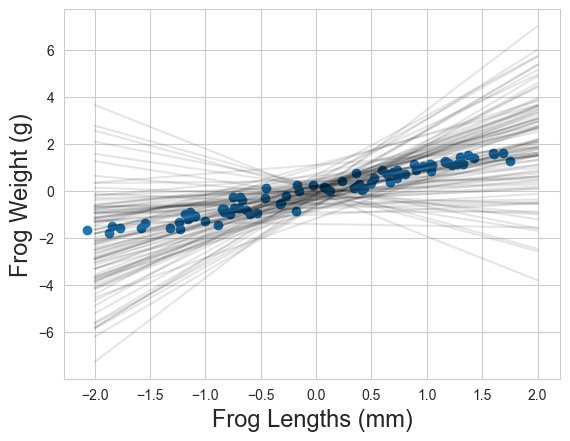

In [187]:
# alpha (intercept) prior
alpha_prior = sp.stats.norm(0,0.5).rvs(n_samps)
# beta (slope/effect_size) prior
betaL_prior = sp.stats.lognorm(loc=0,s=0.2).rvs(size=n_samps)
betaC_prior =  sp.stats.norm(0,1).rvs(size=n_samps)

# Plot resulting lines given sample values for alpha_prior and beta_prior, using a list comprehension
# range to plot over
x_seq = np.linspace(-2, 2, n_samps)
plt.scatter(weights_std, lengths_std)
[plt.plot(length_seq, a_prior+bL_prior*x_seq + bC_prior*x_seq, c='black', alpha=0.1) for a_prior,bL_prior, bC_prior in zip(alpha_prior,betaL_prior, betaC_prior)];
plt.xlabel('Frog Lengths (mm)', fontsize=17)
plt.ylabel('Frog Weight (g)', fontsize=17)

Run our multiple regression

In [182]:
# colour and weight linear regression
with pm.Model() as length_colour_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.8)
    betaL = pm.LogNormal("betaL", 0, 0.2)
    betaC = pm.Normal("betaC", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + betaC*colours + betaL+lengths_std)
    
    # data likelihood
    weight = pm.Normal("weights", mu, sigma, observed=weights_std)
    
    length_colour_idata = pm.sample()

az.summary(length_colour_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betaL, betaC, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.962,0.186,-1.327,-0.627,0.007,0.005,939.0,463.0,1.01
betaC,-0.016,0.037,-0.083,0.056,0.001,0.001,2365.0,2172.0,1.00
betaL,0.964,0.184,0.645,1.336,0.007,0.005,934.0,489.0,1.01
mu[0],-0.243,0.035,-0.304,-0.175,0.001,0.000,3345.0,3066.0,1.00
mu[1],-1.385,0.035,-1.446,-1.314,0.001,0.000,3303.0,3041.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[71],-0.274,0.031,-0.330,-0.214,0.001,0.000,3753.0,3325.0,1.00
mu[72],-0.774,0.052,-0.864,-0.671,0.001,0.001,2760.0,2746.0,1.00
mu[73],1.073,0.031,1.015,1.129,0.000,0.000,3746.0,3220.0,1.00
mu[74],-1.290,0.036,-1.354,-1.220,0.001,0.000,3255.0,3041.0,1.00


When plotting the effect sizes of each of beta parameters we can see the betaC effect drop off completely.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

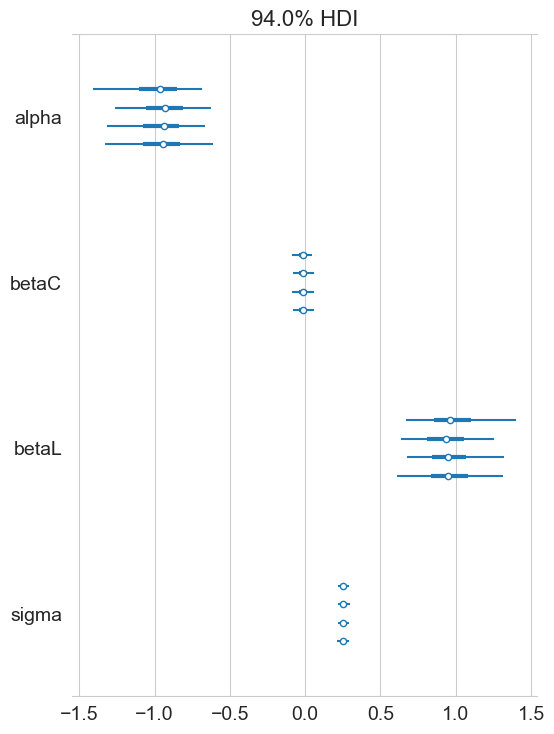

In [183]:
az.plot_forest(length_colour_idata, filter_vars='regex', var_names=['alpha', 'beta', 'sigma'])

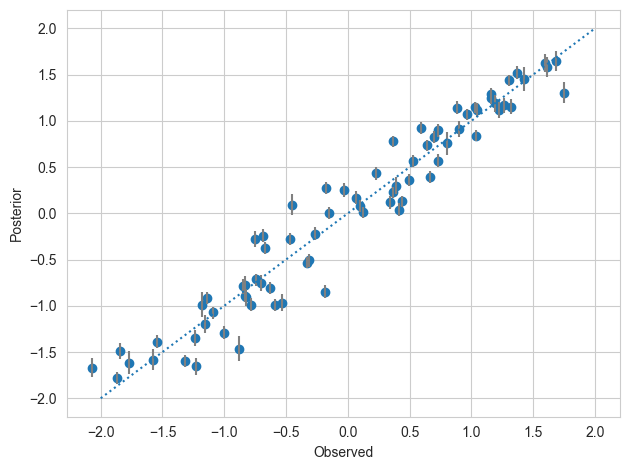

In [185]:
# get estimates of mu for each individual frog and put them in a dataframe
mu = length_colour_idata['posterior']['mu'].values[0,]
# calculate mean of each individual frog
mu_mean = np.median(mu, axis=0)
# uncertainity intervals
y_l95 = np.percentile(mu, 2.5, axis=0)
y_u95 = np.percentile(mu, 97.5, axis=0)
# Plot expected vs observed
plt.vlines(weights_std, y_l95, y_u95, colors='grey')
plt.scatter(weights_std, mu_mean)
plt.plot((-2, 2), (-2, 2), linestyle=":")
plt.xlabel('Observed')
plt.ylabel('Posterior')
plt.tight_layout()
